In [1]:
import pickle as pk
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
import math
import cv2
from sklearn.model_selection import train_test_split


In [2]:
with open('../data/pickles/augmented.pkl', 'rb') as f:
    data = pk.load(f)

In [3]:
images, probs, types = data

In [4]:
y = [probs, types]
y = np.stack(y).T

In [6]:
def min_max_normal(channel, c, d):
    O = (channel.astype('float')-c)*(255/(d-c))
    O = np.clip(O, 0, 255)
    return O.astype('uint8')

def HSV_contrast(I):
    R, G, B = cv2.split(I)

    H, S, V = cv2.split(cv2.cvtColor(I, cv2.COLOR_RGB2HSV))

    c = np.min(V)
    d = np.max(V)

    R = min_max_normal(channel=R, c=c, d=d)
    G = min_max_normal(channel=G, c=c, d=d)
    B = min_max_normal(channel=B, c=c, d=d)

    O = cv2.merge([R, G, B])
    O = cv2.cvtColor(O, cv2.COLOR_RGB2GRAY)

    return O

def contrast_stretch(I):
    kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])
    I = HSV_contrast(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
    I = resize(I, (128, 128))

    gaus = cv2.GaussianBlur(I, (3, 3), 5.0)

    erode = cv2.erode(gaus, kernel=kernel).flatten()
    return erode
    

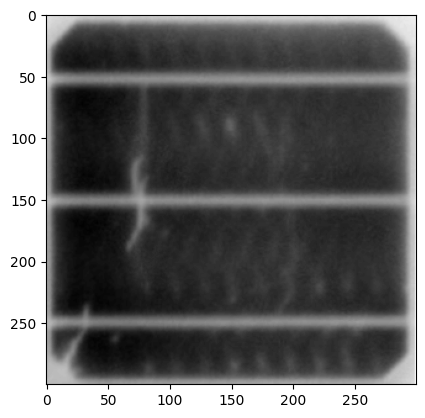

In [7]:
plt.imshow(images[0], cmap= 'gray')

In [8]:
processed = []
for I in images:
    processed.append(contrast_stretch(I))

In [9]:
processed = np.stack(processed)

In [10]:
train_X, test_X, train_y, test_y = train_test_split(processed, y, test_size=0.25, stratify=y)
train_X, test_X = train_X.T, test_X.T

(16384, 7872)


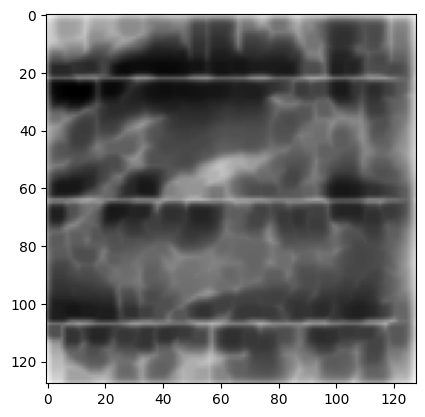

In [20]:
row, col = 128, 128
dimension = (row, col, 1)

print(train_X.shape)
plt.imshow(train_X[:, 0].reshape(dimension), cmap='gray')
plt.show()


In [13]:
def preprocess(I):
    mu = np.mean(I, axis = 1)
    Q = I - mu[:, np.newaxis]
    Q_norm = np.linalg.norm(Q, np.inf, axis = 1)
    Q_norm[Q_norm == 0] = 1
    I = Q/Q_norm[:, np.newaxis]
    return I, Q_norm, mu

In [14]:
I, Q_norms, I_means = preprocess(train_X)
print(I.shape)
print(Q_norms.shape)
print(I_means.shape)

(16384, 7872)
(16384,)
(16384,)


In [15]:
def eigen_cell(I):

    S = (1/I.shape[1])*(I.T@I)
    D, C = np.linalg.eig(S)
    
    C = np.dot(I, C)
    C = C/np.linalg.norm(C, axis = 0)
    
    return C, D



Orthogonality Check (should be close to 0):  5.263723555318214e-16
Unit Vector Check:  True
(16384, 7872)
(7872,)
Visualise an Eigen Solar Cell:


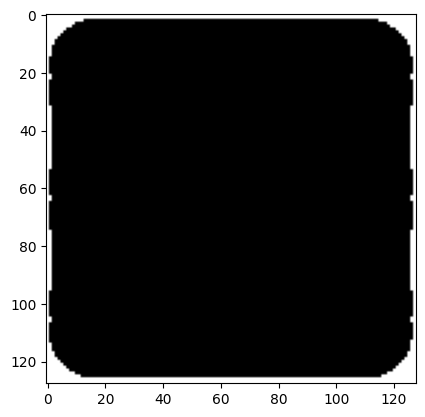

In [19]:
C, D = eigen_cell(I)
C_real = np.real(C)
print('Orthogonality Check (should be close to 0): ', C_real[:, 0].T@C_real[:, 1])
print('Unit Vector Check: ', math.isclose(np.linalg.norm(C_real[:,0]), 1))
print(C.shape)
print(D.shape) 

print('Visualise an Eigen Solar Cell:')
ec = np.rint((C[:, 1] * Q_norms + I_means).reshape(dimension)).astype(int)
plt.imshow(ec, cmap = 'gray')
plt.show()

Visualise an Eigen Solar Cell:


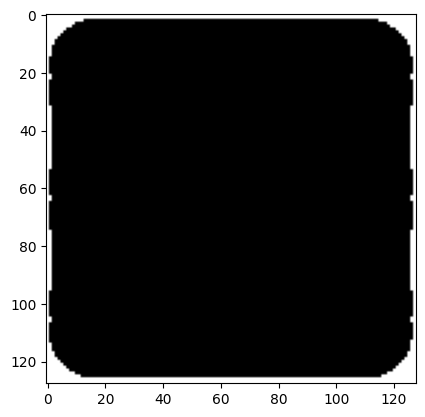

In [21]:
print('Visualise an Eigen Solar Cell:')
ec = np.rint((C[:, 1] * Q_norms + I_means).reshape(dimension)).astype(int)
plt.imshow(ec, cmap = 'gray')
plt.show()

In [35]:
def reduce_dimensionality(I, k, F, D, A_means, Q_norms):
    index = D.argsort()
    D = D[index[::-1]]
    F = F[:, index[::-1]]
    A = I.copy()
    # A_means = A_means.reshape((A_means.shape[0], -1))
    # Q_norms = Q_norms.reshape((Q_norms.shape[0], -1))
    A = A - A_means[:, np.newaxis]
    A = A/Q_norms[:, np.newaxis]
    Z = F.T@A
    Z[:, k:] = 0
    p = np.sum(D[:k])/np.sum(D)
    return Z, p

Idx = 1203
compressed_image, p = reduce_dimensionality(train_X[:, Idx], 80, C, D, I_means, Q_norms)
print(compressed_image.shape)
print('Variance Captured:', int(p * 100), '%')

(7872, 16384)
Variance Captured: 93 %


In [36]:
def reconstruct_image(compressed_image, C, Q_norms, A_means):
    # YOUR CODE HERE
    image = compressed_image.copy()
    print(C.shape, image.shape)
    A = C@image.T
    print(A.shape)
    return A

In [37]:
R_c = reconstruct_image(compressed_image, C, Q_norms, I_means)

(16384, 7872) (7872, 16384)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 16384 is different from 7872)

Compressed Image: 


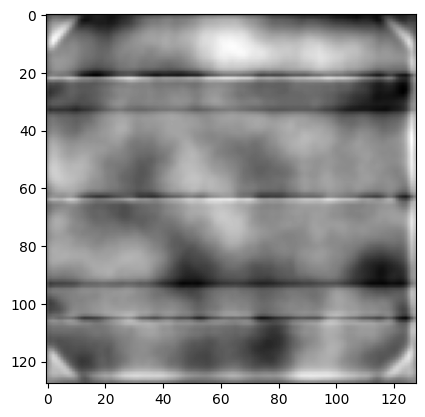

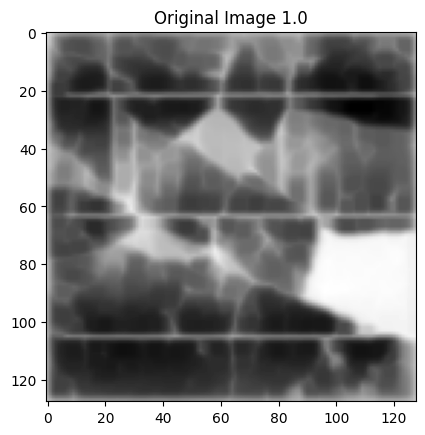

In [34]:
print('Compressed Image: ')
plt.imshow(R_c[:, Idx].reshape(dimension), cmap = 'gray')
plt.show()
R_o = train_X[:, Idx].reshape(dimension)
plt.title(f'Original Image {train_y[Idx, 0]}')
plt.imshow(R_o, cmap = 'gray')
plt.show()

In [31]:
def the_nearest_image(query_image, gallery_images, k, F, D, A_means, Q_norms):
    # YOUR CODE HERE

    gallery_images = (gallery_images-A_means[:, np.newaxis])/Q_norms[:, np.newaxis]
    print(gallery_images.shape)
    image_reduce, p = reduce_dimensionality(query_image, k, F, D, A_means, Q_norms)
    print(image_reduce.shape)
    queries = reconstruct_image(image_reduce, F, Q_norms, A_means)
    print(queries.shape)
    norms = np.linalg.norm(gallery_images-queries, axis=0)
    print(norms.shape)
    return
    index = np.argmin(norms)
    return index
# Display Code. Leave it alooooooooooone.
# read a query image
query_image = test_X[:, 1]

idx = the_nearest_image(query_image, train_X, 90, C, D, I_means, Q_norms)

(16384, 7872)
(7872, 16384)
(16384, 7872) (7872, 16384)
(16384, 16384)
(16384, 16384)


ValueError: operands could not be broadcast together with shapes (16384,7872) (16384,16384) 

In [ ]:
plt.imshow(query_image.reshape(dimension), cmap='gray')
plt.title(f"Prob: {test_y[1, 0]}")
plt.show()
plt.imshow(train_X[:, idx].reshape(dimension), cmap = 'gray')
plt.title(f"Prob: {train_y[idx, 0]}")
plt.show()

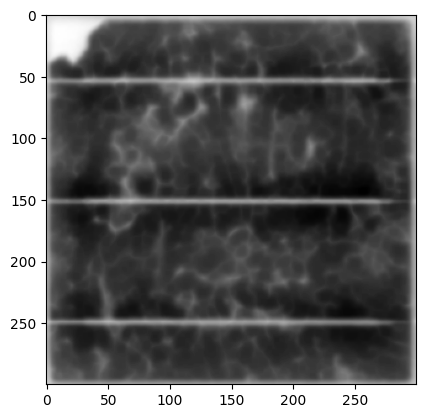

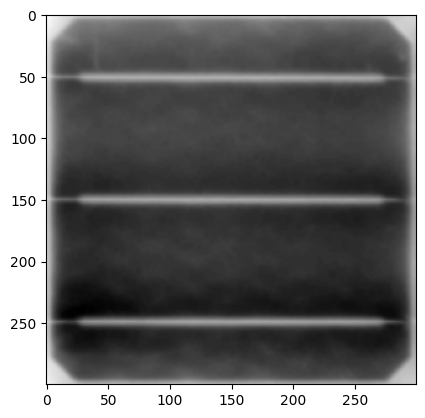

In [63]:
def image_similarity_ranking(image_gallery, image_query):
    # YOUR CODE HERE
    train = image_gallery

    A, Q_norms, A_means = preprocess(train)
    F, D = eigen_cell(A)
    query = image_query.flatten()
    image_reduce, p = reduce_dimensionality(query, min(F.shape), F, D, A_means, Q_norms)
    image_compress = reconstruct_image(image_reduce, F, Q_norms, A_means)
    query = image_compress.flatten()
    query = query.reshape(query.shape[0], -1)
    norms = np.linalg.norm(A-query, axis=0)
    indices = np.argsort(norms)
    return indices
# Display Code. Leave it alooooooooooone.

id_list = image_similarity_ranking(train_X, test_X[:, 0])

plt.imshow(test_X[:, 0].reshape(dimension), cmap = 'gray')
plt.show()
plt.imshow(train_X[:, id_list[0]].reshape(dimension), cmap = 'gray')
plt.show()

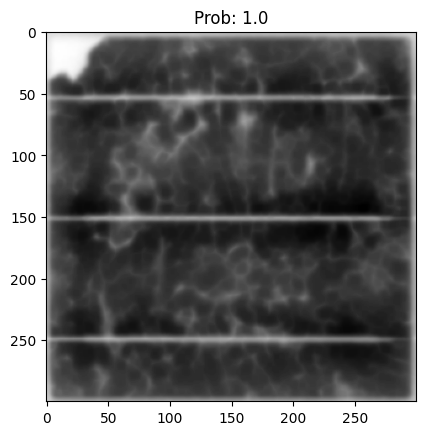

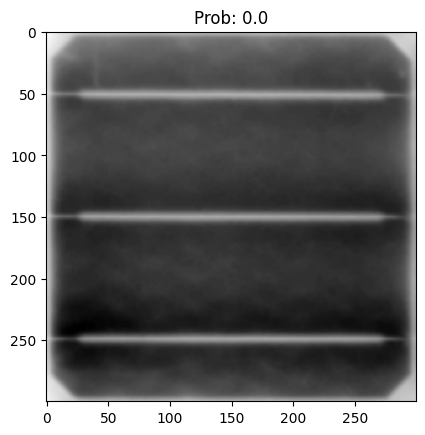

In [68]:
plt.imshow(test_X[:, 0].reshape(dimension), cmap = 'gray')
plt.title(f"Prob: {test_y[0, 0]}")
plt.show()
plt.imshow(train_X[:, id_list[0]].reshape(dimension), cmap = 'gray')
plt.title(f"Prob: {train_y[id_list[0], 0]}")
plt.show()